In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.1.1
    Uninstalling pydantic-2.1.1:
    

In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from IPython.display import clear_output
from typing import NamedTuple
from datetime import timedelta, datetime
import yfinance as yf

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt


class SinglePeriod:
    def __init__(
        self,
        data,
        preds,
        budget,
        init_budget,
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):

        self.df = data
        self.preds = preds
        self.budget = budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.init_budget = budget

        #print('self.df.columns')
        #print(self.df.columns)
        self.stocks = self.df.columns.tolist()
        self.init_holdings = init_holdings
        #print(f'self.init_holdings in single period: {init_holdings}')

        self.pct_returns = self.df.pct_change()

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")
        #print(f'self.alpha: {self.alpha}')

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.solution = {}
        self.precision = 2


    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        print(f'idx in single period: {idx}')
        self.price = self.df.loc[idx, :]
        print('price')
        display(self.price)
        self.daily_returns = self.pct_returns.loc[:idx, :]
        print('daily returns')
        display(self.daily_returns)
        self.avg_daily_returns = self.preds.pct_change().loc[idx, :]
        print('avg daily returns')
        display(self.avg_daily_returns)
        self.covariance_matrix = self.daily_returns.cov()

        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]

        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'init holdings total value: {sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}')
            #self.budget = sum([self.price[s]*self.init_holdings[s] for s in self.stocks])
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0
            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')

            print(f'budget in cqm: {self.budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')


        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            # print(f'risk: {type(risk)}')
            # print(f'returns: {type(returns)}')
            #print(returns)

            cqm.set_objective(self.alpha * risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm
        return self.model



    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.model = self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            #print(f'stock: {stock}, price1: {self.price[s1]}, price2: {self.price[s2]}, covariance_matrix: {self.covariance_matrix[s1][s2]}')
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        #tmp_daily_retuns = self.avg_daily_returns.loc[idx, :]
        for stock in solution:
            #print(f'stock: {stock}, price: {self.price[stock]}, avg_daily_returns: {self.avg_daily_returns[stock]}')
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]
            #est_return += solution[stock]*self.price[stock]*self.tmp_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self,
                data,
                forecast,
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):

        self.save_path = save_path
        self.df = data
        self.preds = forecast
        print('self.preds')
        display(self.preds)
        self.stocks = self.df.columns.values.tolist()

        self.sampler_args = sampler_args
        self.budget = budget
        self.init_budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type

        initial_gspc = self.baseline.query('ds==@dates[0]').values.tolist()[0][0]
        # print('initial baseline')
        # display(self.baseline)
        # print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        # print('final baseline')
        # display(self.baseline)
        # print('initial data')
        # display(self.df.head())

        self.init_holdings = init_holdings
        # if init_holdings is not None:
        #     self.init_holdings = init_holdings
        # else:
        #     self.init_holdings = {s:0 for s in self.stocks}

        # print('iniital_holdings')
        # print(self.init_holdings)

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        # print('init holdings keys')
        # print(set(self.init_holdings.keys()))
        #self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = self.df.columns.values.tolist()
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)
        self.sample_set = {}
        self.sampler_args = sampler_args
        self.solution = {}

    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """

        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []

        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'est_returns', 'value'])


        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')

            previous_idx = idx - timedelta(days=1)
            self.price = self.df.loc[idx, :]
            print('price')
            display(self.price)
            baseline_current = self.baseline.loc[idx, :]

            if first_purchase:
                self.budget = self.init_budget
                #self.agg_results = pd.DataFrame([{'idx': idx, 'variance': 0.0, 'est_returns': 0.0, 'value': sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}])

                print('preds')
                display(self.preds.loc[idx, :])
                print(f'budget in Multiperiod: {self.budget}')

                first_purchase = False
            else:
                self.budget = sum([self.price[s] * self.init_holdings[s] for s in self.stocks])
                print(f'budget in Multiperiod: {self.budget}')

            single_period = SinglePeriod(data=self.df.loc[:idx, :],
                                            preds=self.preds,
                                            budget=self.budget,
                                            init_budget = self.init_budget,
                                            sampler_args=self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            baseline_shares = (self.budget / baseline_current)
            #display(self.baseline)
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            returns = self.solution['return']
            variance = self.solution['risk']
            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'est_returns': returns, 'value': value}])])

            #initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / self.budget - 1
            display(self.agg_results)

            # fig = plt.figure(figsize=(10.708,8.2))
            # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            # plt.show()
            # print(f'\nRun completed.\n')

        return self.agg_results

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)

    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    df_baseline = pd.DataFrame(index=index_df.index, columns=baseline)
    for i in baseline:
        df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:
                if b == '0':
                    inverse_s += '1'
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)

            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            print(total)
            if total <= budget and total > 0.6 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(score_report)
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0
    # enumerate generations
    for gen in range(n_iter):
        print(gen)
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]

        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
            ax[0].hist(scores)
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
ticker_list = first_table['Symbol'].values.tolist()
source = yf.download(ticker_list, start=initial_date, end=end_date)[['Close']]
df_src = source.copy()
df_src.columns = df_src.columns.droplevel(0)
df_src.dropna(axis=1, inplace=True)
stock_list = df_src.columns.values.tolist()
df_src.reset_index(inplace=True)
df_src.rename(columns={'Date':'ds'}, inplace=True)
df_src.set_index('ds', inplace=True)
df_src.head()

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1625112000")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 -> 2021-07-01)')


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.639999,15.13,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996,...,106.900002,65.660004,41.500000,53.750000,99.690002,105.820000,148.699036,378.130005,42.930000,163.589996
2021-01-05,119.610001,15.43,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002,...,110.190002,65.019997,43.500000,55.290001,99.570000,105.830002,151.271851,380.570007,43.610001,164.729996
2021-01-06,122.889999,15.52,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998,...,110.849998,66.459999,44.610001,57.959999,103.769997,106.410004,155.582520,394.820007,48.509998,167.149994
2021-01-07,126.160004,15.38,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990,...,109.750000,65.160004,44.959999,57.660000,108.480003,105.599998,154.660187,409.100006,49.990002,167.000000
2021-01-08,127.059998,15.13,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006,...,109.029999,65.760002,45.459999,58.180000,107.379997,107.150002,154.320389,405.470001,48.720001,168.110001


In [9]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
source = yf.download(['^GSPC'], start=initial_date, end=end_date)[['Close']]
df_baseline = source.copy()
display(df_baseline.head())
df_baseline = source[['Close']]
df_baseline.dropna(axis=1, inplace=True)
df_baseline.reset_index(inplace=True)
df_baseline.rename(columns={'Date':'ds'}, inplace=True)
df_baseline.set_index('ds', inplace=True)
df_baseline.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


,Close
ds,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [10]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.01,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'n_iter': 100,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Experiment 1',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}

df_forecast_init = pd.read_pickle('/content/drive/MyDrive/models/lgbm_20_backtest.pkl')
df_forecast_init.index.names = ['ds']
print('df_forecast_init')
display(df_forecast_init.tail())
n_stocks = 4
stocks = df_forecast_init.columns.values.tolist()[:n_stocks]

# print('df')
# display(df.loc[:, stocks].shift(1).head())
# display(df.loc[:, stocks].shift(1).tail())
df = df_src.loc[:, stocks].shift(1)
df.dropna(inplace=True)
display(df.head())


df_forecast = df_src.loc[:, stocks].copy()
#df_forecast = pd.concat([df.loc[:(datetime.strptime(cfg['dates'][0], '%Y-%m-%d') - timedelta(days=1)), :], df_forecast_init], axis=0)


df_forecast_init


component,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ
ds,,,,,,,,,,,,,,,,,,,,
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398,110.770653,38.518082,286.168220,557.019597,163.760820,61.415389,195.987823,283.222162,82.608674,83.349458,25.624797,52.799280,47.613560,154.537456
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139,111.652757,38.897167,288.404758,558.395945,165.247477,61.819882,196.153547,287.207009,81.194616,83.090155,25.801721,52.910658,47.802288,155.703599
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338,112.102045,39.150949,291.016352,558.459812,166.915255,61.930524,196.802058,288.886774,81.919258,84.270725,26.230586,54.662100,49.180730,157.439943
2021-06-29,145.405624,21.009751,204.094801,134.260115,112.648726,114.900173,113.982671,38.643299,291.487102,570.658734,166.156724,61.283882,195.745522,295.854965,81.933233,85.141641,26.788827,53.393008,47.777303,156.951892
2021-06-30,146.019711,21.378169,204.518649,134.139080,112.492505,115.130130,114.293718,39.001348,291.728585,571.483641,168.679069,61.458320,195.428718,295.781137,80.670301,83.853520,26.031758,53.714718,47.578363,156.551092


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,118.639999,15.13,157.339996,129.410004
2021-01-06,119.610001,15.43,157.169998,131.009995
2021-01-07,122.889999,15.52,166.250000,126.599998
2021-01-08,126.160004,15.38,167.669998,130.919998
2021-01-11,127.059998,15.13,170.059998,132.050003


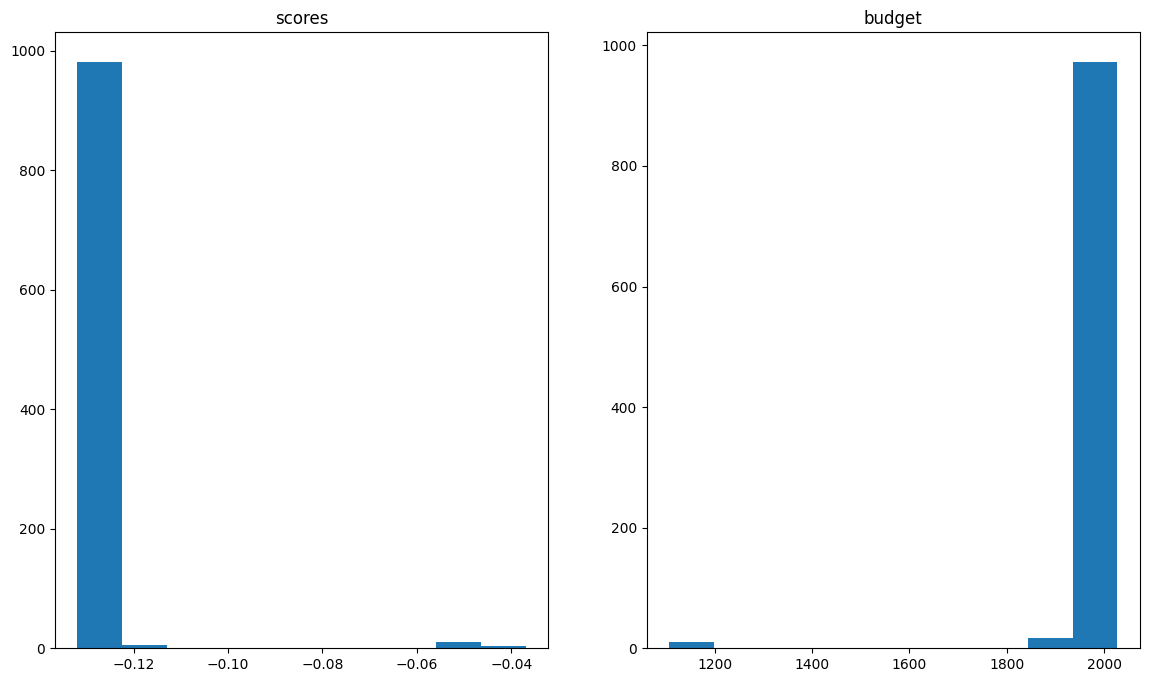

90 best eval:-0.1319549938021196
mean score: -0.13074688422398867
best total: 2012.3300170898438
91
92
93
94
95
96
97
98
99
best: [8 0 1 7]
best_eval: -0.1319549938021196
best_total: 2012.3300170898438
pop: [8, 0, 1, 7]


In [11]:
init_holdings_df, budget = generate_initial_state(df, cfg['n_iter'], cfg['r_cross'], cfg['r_mut'], cfg['n_pop'], cfg['budget'])
init_holdings_df.to_pickle(cfg['save_path']+'init_holdings.pkl')

#init_holdings_df = pd.read_pickle(cfg['save_path']+'init_holdings.pkl')
init_holdings = {}

for idx, row in init_holdings_df.iterrows():
    init_holdings.update({row['a']: row['b']})

prices = df.loc[cfg['dates'][0], :].values.tolist()
pop = init_holdings_df['b'].values.tolist()
print(f'pop: {pop}')
budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])

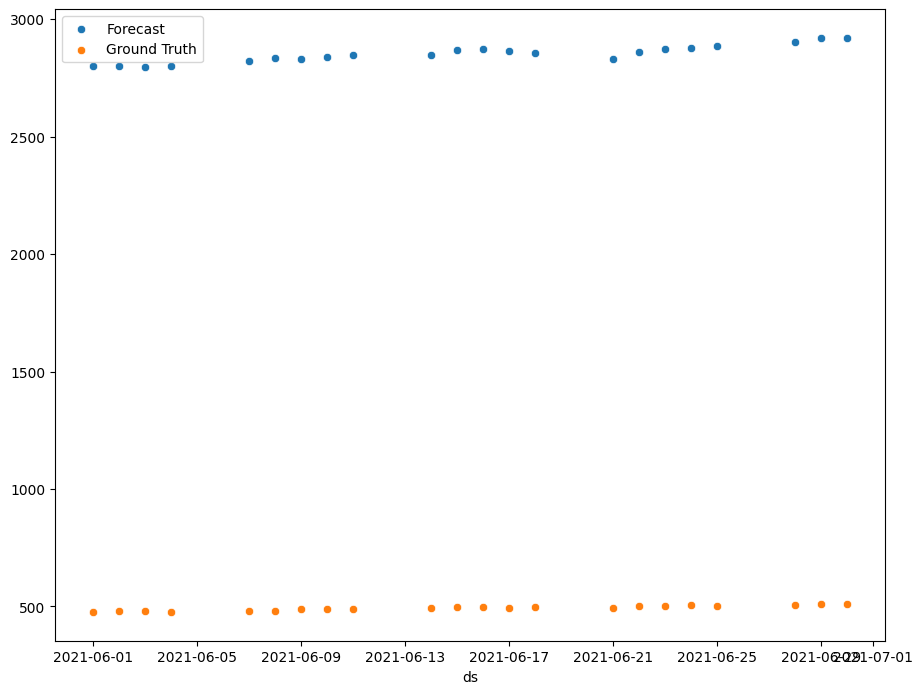

In [12]:
# fig = plt.figure(figsize=(10.708,8.2))
# sns.scatterplot(x='ds', y=df_forecast_init.sum(axis=1), data=df_forecast_init, label='Forecast')
# sns.scatterplot(x='ds', y=df.sum(axis=1), data=df.loc['2021-06-01':, :], label='Ground Truth')
# # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
# # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
# plt.show()

In [13]:
my_portfolio = MultiPeriod(data=df,
                        forecast=df_forecast,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=cfg['sampler_args'],
                        dates=cfg['dates'],
                        file_path=cfg['file_path'],
                        model_type=cfg['model_type'],
                        alpha=cfg['alpha'],
                        verbose=cfg['verbose'],
                        t_cost=cfg['t_cost'],
                        label=cfg['label'],
                        init_holdings=init_holdings,
                        save_path=cfg['save_path']+cfg['label']+'/'
                        )

df_results = my_portfolio.run(min_return=cfg['min_return'], max_risk=cfg['max_risk'], num=cfg['num'])

self.preds


,A,AAL,AAP,AAPL
ds,,,,
2021-01-04,118.639999,15.130000,157.339996,129.410004
2021-01-05,119.610001,15.430000,157.169998,131.009995
2021-01-06,122.889999,15.520000,166.250000,126.599998
2021-01-07,126.160004,15.380000,167.669998,130.919998
2021-01-08,127.059998,15.130000,170.059998,132.050003
...,...,...,...,...
2021-06-24,146.669998,22.350000,200.960007,133.410004
2021-06-25,147.279999,22.219999,204.429993,133.110001
2021-06-28,147.929993,21.389999,204.509995,134.779999


num_days: 22
idx: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
Name: 2021-06-01 00:00:00, dtype: float64

preds


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
Name: 2021-06-01 00:00:00, dtype: float64

budget in Multiperiod: 2167.0400390625
idx in single period: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
Name: 2021-06-01 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-25,0.007861,0.018609,-0.022007,0.013314
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574
2021-05-27,0.000450,0.029729,0.005372,-0.000394


avg daily returns


A      -0.006733
AAL     0.017739
AAP     0.025932
AAPL   -0.002648
Name: 2021-06-01 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.8219217308581452, ('AAL', 'A'): 0.3004361348299089, ('AAL', 'AAL'): 0.5971390850627484, ('AAP', 'A'): 3.084812756080672, ('AAP', 'AAL'): 0.8922472870678483, ('AAP', 'AAP'): 12.782089303041534, ('AAPL', 'A'): 3.9318521004513696, ('AAPL', 'AAL'): -0.1564171703973175, ('AAPL', 'AAP'): -2.5542724808131565, ('AAPL', 'AAPL'): 5.345321915842802}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.9300079345703086, 'AAL': 0.4300003051757793, 'AAP': 4.919998168945306, 'AAPL': -0.330001831054685}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 72
solution_stocks: {'A': 0, 'AAL': 11, 'AAP': 10, 'AAPL': 0}
solution_return: 53.93
solution_risk: 1448.61
spending: 1974.2099590301514
sales: 1977.310043334961
transaction: 0.0

Estimated Returns: 53.93
Sales Revenue: 19

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.001431


idx: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
Name: 2021-06-02 00:00:00, dtype: float64

budget in Multiperiod: 2217.869939804077
idx in single period: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
Name: 2021-06-02 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574
2021-05-27,0.000450,0.029729,0.005372,-0.000394
2021-05-28,0.031885,0.022176,-0.001958,-0.012377


avg daily returns


A      -0.004592
AAL     0.046615
AAP    -0.017056
AAPL    0.006276
Name: 2021-06-02 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.7461312294742175, ('AAL', 'A'): 0.29374542603379994, ('AAL', 'AAL'): 0.6133308907988754, ('AAP', 'A'): 3.008005344024307, ('AAP', 'AAL'): 0.9506770565623233, ('AAP', 'AAP'): 13.532589944430853, ('AAPL', 'A'): 3.8632875702193203, ('AAPL', 'AAL'): -0.15904487573611703, ('AAPL', 'AAP'): -2.61540379244957, ('AAPL', 'AAPL'): 5.2653083603576665}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.6299896240234346, 'AAL': 1.1499996185302723, 'AAP': -3.319992065429695, 'AAPL': 0.7799987792968801}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 93
solution_stocks: {'A': 1, 'AAL': 74, 'AAP': 0, 'AAPL': 2}
solution_return: 86.03
solution_risk: 3389.33
spending: 1939.9699993133545
sales: 1946.4999389648438
transaction: 0.0

Estimated Returns: 86.03
Sales Revenue: 

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.024316
0,2021-06-02,3389.33,86.03,2211.340000,-0.002944


idx: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
Name: 2021-06-03 00:00:00, dtype: float64

budget in Multiperiod: 2297.3699798583984
idx in single period: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
Name: 2021-06-03 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-27,0.000450,0.029729,0.005372,-0.000394
2021-05-28,0.031885,0.022176,-0.001958,-0.012377
2021-06-01,0.004290,-0.007777,0.005778,-0.005348


avg daily returns


A      -0.001465
AAL    -0.034469
AAP    -0.000993
AAPL   -0.012154
Name: 2021-06-03 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.682191618844847, ('AAL', 'A'): 0.2857224888633553, ('AAL', 'AAL'): 0.6763082528903048, ('AAP', 'A'): 2.974230770134162, ('AAP', 'AAL'): 0.8918531302668526, ('AAP', 'AAP'): 13.079394308772791, ('AAPL', 'A'): 3.818552397376063, ('AAPL', 'AAL'): -0.14901159723971602, ('AAPL', 'AAP'): -2.6199545508825155, ('AAPL', 'AAPL'): 5.285760056209415}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.2000122070312444, 'AAL': -0.8899993896484385, 'AAP': -0.19000244140624536, 'AAPL': -1.5199966430664087}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 84
solution_stocks: {'A': 14, 'AAL': 0, 'AAP': 2, 'AAPL': 0}
solution_return: -3.18
solution_risk: 857.31
spending: 2158.070098876953
sales: 2160.7999725341797
transaction: 0.0

Estimated Returns: -3.18
Sales Revenue: 

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.058079
0,2021-06-02,3389.33,86.03,2211.340000,-0.037447
0,2021-06-03,857.31,-3.18,2294.640106,-0.001188


idx: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
Name: 2021-06-04 00:00:00, dtype: float64

budget in Multiperiod: 2291.459930419922
idx in single period: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
Name: 2021-06-04 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-05-28,0.031885,0.022176,-0.001958,-0.012377
2021-06-01,0.004290,-0.007777,0.005778,-0.005348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648


avg daily returns


A       0.011219
AAL    -0.025271
AAP     0.008475
AAPL    0.019022
Name: 2021-06-04 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.6373042041895562, ('AAL', 'A'): 0.2804892820155398, ('AAL', 'AAL'): 0.6340084441449609, ('AAP', 'A'): 2.9426303555360684, ('AAP', 'AAL'): 0.86320742530933, ('AAP', 'AAP'): 12.930010253330853, ('AAPL', 'A'): 3.741428150071202, ('AAPL', 'AAL'): -0.1122235759468937, ('AAPL', 'AAP'): -2.543719855008465, ('AAPL', 'AAPL'): 5.129069951447265}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.529998779296877, 'AAL': -0.6300010681152352, 'AAP': 1.6199951171875109, 'AAPL': 2.349998474121089}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 82
solution_stocks: {'A': 0, 'AAL': 0, 'AAP': 1, 'AAPL': 17}
solution_return: 41.57
solution_risk: 1451.99
spending: 2100.180015563965
sales: 2100.3199310302734
transaction: 0.0

Estimated Returns: 41.57
Sales Revenue: 2100.32

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.055650
0,2021-06-02,3389.33,86.03,2211.340000,-0.034965
0,2021-06-03,857.31,-3.18,2294.640106,0.001388
0,2021-06-04,1451.99,41.57,2291.320015,-0.000061


idx: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
Name: 2021-06-07 00:00:00, dtype: float64

budget in Multiperiod: 2332.8899841308594
idx in single period: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
Name: 2021-06-07 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-01,0.004290,-0.007777,0.005778,-0.005348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648
2021-06-03,-0.004592,0.046615,-0.017056,0.006276


avg daily returns


A      -0.001813
AAL    -0.002058
AAP     0.001297
AAPL    0.000079
Name: 2021-06-07 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.700947155218335, ('AAL', 'A'): 0.25471482606233925, ('AAL', 'AAL'): 0.6018372937201335, ('AAP', 'A'): 3.0038443123186553, ('AAP', 'AAL'): 0.8228286324696978, ('AAP', 'AAP'): 13.038288700933837, ('AAPL', 'A'): 3.880740186112491, ('AAPL', 'AAL'): -0.14479322738442651, ('AAPL', 'AAP'): -2.5315982199431453, ('AAPL', 'AAPL'): 5.331080574092813}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.25000000000000383, 'AAL': -0.04999923706054593, 'AAP': 0.2499999999999946, 'AAPL': 0.010002136230462933}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 91
solution_stocks: {'A': 1, 'AAL': 9, 'AAP': 5, 'AAPL': 8}
solution_return: 0.63
solution_risk: 693.29
spending: 1127.639965057373
sales: 1133.009994506836
transaction: 0.0

Estimated Returns: 0.63
Sales Revenue: 1

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.072421
0,2021-06-02,3389.33,86.03,2211.340000,-0.052103
0,2021-06-03,857.31,-3.18,2294.640106,-0.016396
0,2021-06-04,1451.99,41.57,2291.320015,-0.017819
0,2021-06-07,693.29,0.63,2327.519955,-0.002302


idx: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
Name: 2021-06-08 00:00:00, dtype: float64

budget in Multiperiod: 2328.1499786376953
idx in single period: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
Name: 2021-06-08 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-02,-0.006733,0.017739,0.025932,-0.002648
2021-06-03,-0.004592,0.046615,-0.017056,0.006276
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154


avg daily returns


A       0.007991
AAL    -0.001237
AAP     0.025180
AAPL    0.006672
Name: 2021-06-08 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.654418795133471, ('AAL', 'A'): 0.25280375071626976, ('AAL', 'AAL'): 0.5939328911542284, ('AAP', 'A'): 2.97505579789797, ('AAP', 'AAL'): 0.814877940913606, ('AAP', 'AAP'): 12.947866156272763, ('AAPL', 'A'): 3.8369252035535073, ('AAPL', 'AAL'): -0.1432021300782204, ('AAPL', 'AAP'): -2.5110047457806317, ('AAPL', 'AAPL'): 5.2811520787904}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.1000061035156263, 'AAL': -0.030000686645508895, 'AAP': 4.8600006103515625, 'AAPL': 0.8399963378906286}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 97
solution_stocks: {'A': 0, 'AAL': 3, 'AAP': 11, 'AAPL': 1}
solution_return: 54.21
solution_risk: 1576.16
spending: 1158.0599670410156
sales: 1164.4500045776367
transaction: 0.0

Estimated Returns: 54.21
Sales Revenue: 116

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.070532
0,2021-06-02,3389.33,86.03,2211.340000,-0.050173
0,2021-06-03,857.31,-3.18,2294.640106,-0.014393
0,2021-06-04,1451.99,41.57,2291.320015,-0.015819
0,2021-06-07,693.29,0.63,2327.519955,-0.000271
0,2021-06-08,1576.16,54.21,2321.759941,-0.002745


idx: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
Name: 2021-06-09 00:00:00, dtype: float64

budget in Multiperiod: 2375.9699420928955
idx in single period: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
Name: 2021-06-09 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-03,-0.004592,0.046615,-0.017056,0.006276
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154
2021-06-07,0.011219,-0.025271,0.008475,0.019022


avg daily returns


A       0.009946
AAL    -0.015277
AAP    -0.004245
AAPL    0.003077
Name: 2021-06-09 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.685614981121643, ('AAL', 'A'): 0.24958297846398692, ('AAL', 'AAL'): 0.5870850686263431, ('AAP', 'A'): 3.1222298718115944, ('AAP', 'AAL'): 0.8136936105770312, ('AAP', 'AAP'): 13.674639658044171, ('AAPL', 'A'): 3.871101636034324, ('AAPL', 'AAL'): -0.1450243890266192, ('AAPL', 'AAP'): -2.493761166887192, ('AAPL', 'AAPL'): 5.3082421937701}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.3800048828125056, 'AAL': -0.369998931884765, 'AAP': -0.8399963378906283, 'AAPL': 0.3899993896484297}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 78
solution_stocks: {'A': 16, 'AAL': 1, 'AAP': 0, 'AAPL': 1}
solution_return: 22.1
solution_risk: 1015.2
spending: 2220.0
sales: 2225.0099449157715
transaction: 0.0

Estimated Returns: 22.1
Sales Revenue: 2225.01
Purchase Co

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.089239
0,2021-06-02,3389.33,86.03,2211.340000,-0.069290
0,2021-06-03,857.31,-3.18,2294.640106,-0.034230
0,2021-06-04,1451.99,41.57,2291.320015,-0.035628
0,2021-06-07,693.29,0.63,2327.519955,-0.020392
0,2021-06-08,1576.16,54.21,2321.759941,-0.022816
0,2021-06-09,1015.20,22.10,2370.959997,-0.002109


idx: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
Name: 2021-06-10 00:00:00, dtype: float64

budget in Multiperiod: 2393.0600757598877
idx in single period: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
Name: 2021-06-10 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154
2021-06-07,0.011219,-0.025271,0.008475,0.019022
2021-06-08,-0.001813,-0.002058,0.001297,0.000079


avg daily returns


A       0.020909
AAL    -0.016352
AAP    -0.005989
AAPL   -0.008023
Name: 2021-06-10 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.7369482443546627, ('AAL', 'A'): 0.2354243872332346, ('AAL', 'AAL'): 0.5661075619692073, ('AAP', 'A'): 3.082411773399835, ('AAP', 'AAL'): 0.8019252456537828, ('AAP', 'AAP'): 13.447546539989894, ('AAPL', 'A'): 3.8935834724786114, ('AAPL', 'AAL'): -0.145430372138949, ('AAPL', 'AAP'): -2.4769996562095966, ('AAPL', 'AAPL'): 5.292491515970255}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 2.9299926757812407, 'AAL': -0.3900012969970712, 'AAP': -1.1799926757812607, 'AAPL': -1.0199966430664056}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 96
solution_stocks: {'A': 16, 'AAL': 1, 'AAP': 0, 'AAPL': 1}
solution_return: 45.47
solution_risk: 1028.44
spending: 0.0
sales: 0.0
transaction: 0.0

Estimated Returns: 45.47
Sales Revenue: 0.00
Purchase Cost: 0.00
Trans

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.095744
0,2021-06-02,3389.33,86.03,2211.340000,-0.075936
0,2021-06-03,857.31,-3.18,2294.640106,-0.041127
0,2021-06-04,1451.99,41.57,2291.320015,-0.042515
0,2021-06-07,693.29,0.63,2327.519955,-0.027388
0,2021-06-08,1576.16,54.21,2321.759941,-0.029795
0,2021-06-09,1015.20,22.10,2370.959997,-0.009235
0,2021-06-10,1028.44,45.47,2393.060076,0.000000


idx: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
Name: 2021-06-11 00:00:00, dtype: float64

budget in Multiperiod: 2438.529960632324
idx in single period: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
Name: 2021-06-11 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-07,0.011219,-0.025271,0.008475,0.019022
2021-06-08,-0.001813,-0.002058,0.001297,0.000079
2021-06-09,0.007991,-0.001237,0.025180,0.006672


avg daily returns


A       0.003285
AAL     0.002984
AAP     0.018330
AAPL    0.009833
Name: 2021-06-11 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9285283392862484, ('AAL', 'A'): 0.2092321882318528, ('AAL', 'AAL'): 0.5449126918400486, ('AAP', 'A'): 3.0173580287580903, ('AAP', 'AAL'): 0.7914684242714172, ('AAP', 'AAP'): 13.187855170317793, ('AAPL', 'A'): 3.8554222214021356, ('AAPL', 'AAL'): -0.13142033741313933, ('AAPL', 'AAP'): -2.389823737163668, ('AAPL', 'AAPL'): 5.169071345228281}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.4700012207031208, 'AAL': 0.07000160217284905, 'AAP': 3.5899963378906117, 'AAPL': 1.2399978637695308}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 96
solution_stocks: {'A': 1, 'AAL': 1, 'AAP': 9, 'AAPL': 4}
solution_return: 37.81
solution_risk: 1118.75
spending: 2140.9800567626953
sales: 2145.8999633789062
transaction: 0.0

Estimated Returns: 37.81
Sales Revenue: 2

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.112605
0,2021-06-02,3389.33,86.03,2211.340000,-0.093167
0,2021-06-03,857.31,-3.18,2294.640106,-0.059007
0,2021-06-04,1451.99,41.57,2291.320015,-0.060368
0,2021-06-07,693.29,0.63,2327.519955,-0.045523
0,2021-06-08,1576.16,54.21,2321.759941,-0.047885
0,2021-06-09,1015.20,22.10,2370.959997,-0.027709
0,2021-06-10,1028.44,45.47,2393.060076,-0.018646
0,2021-06-11,1118.75,37.81,2433.610054,-0.002018


idx: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
Name: 2021-06-14 00:00:00, dtype: float64

budget in Multiperiod: 2471.420015335083
idx in single period: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
Name: 2021-06-14 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-08,-0.001813,-0.002058,0.001297,0.000079
2021-06-09,0.007991,-0.001237,0.025180,0.006672
2021-06-10,0.009946,-0.015277,-0.004245,0.003077


avg daily returns


A       0.005992
AAL    -0.022949
AAP    -0.004262
AAPL    0.024578
Name: 2021-06-14 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.918510626434786, ('AAL', 'A'): 0.20847593295246214, ('AAL', 'AAL'): 0.5431521753005165, ('AAP', 'A'): 3.066847725902212, ('AAP', 'AAL'): 0.7988540848977588, ('AAP', 'AAP'): 13.644602114616825, ('AAPL', 'A'): 3.875131881832222, ('AAPL', 'AAL'): -0.13271435798633424, ('AAPL', 'AAP'): -2.361116776491427, ('AAPL', 'AAPL'): 5.237338564923023}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.8600006103515494, 'AAL': -0.5400009155273433, 'AAP': -0.8500061035156359, 'AAPL': 3.129997253417958}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 101
solution_stocks: {'A': 0, 'AAL': 2, 'AAP': 0, 'AAPL': 19}
solution_return: 58.39
solution_risk: 1887.81
spending: 1933.779977798462
sales: 1938.4900207519531
transaction: 0.0

Estimated Returns: 58.39
Sales Revenue: 19

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.124414
0,2021-06-02,3389.33,86.03,2211.340000,-0.105235
0,2021-06-03,857.31,-3.18,2294.640106,-0.071530
0,2021-06-04,1451.99,41.57,2291.320015,-0.072873
0,2021-06-07,693.29,0.63,2327.519955,-0.058226
0,2021-06-08,1576.16,54.21,2321.759941,-0.060556
0,2021-06-09,1015.20,22.10,2370.959997,-0.040649
0,2021-06-10,1028.44,45.47,2393.060076,-0.031706
0,2021-06-11,1118.75,37.81,2433.610054,-0.015299
0,2021-06-14,1887.81,58.39,2466.709972,-0.001906


idx: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
Name: 2021-06-15 00:00:00, dtype: float64

budget in Multiperiod: 2525.0999183654785
idx in single period: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
Name: 2021-06-15 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-09,0.007991,-0.001237,0.025180,0.006672
2021-06-10,0.009946,-0.015277,-0.004245,0.003077
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023


avg daily returns


A       0.001593
AAL    -0.008699
AAP     0.010424
AAPL   -0.006438
Name: 2021-06-15 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9328155472515967, ('AAL', 'A'): 0.19621142330686964, ('AAL', 'AAL'): 0.5173826586167763, ('AAP', 'A'): 3.0299676791820405, ('AAP', 'AAL'): 0.7850101121827002, ('AAP', 'AAP'): 13.420986623032253, ('AAPL', 'A'): 3.992579363005602, ('AAPL', 'AAL'): -0.16809384930359583, ('AAPL', 'AAP'): -2.4625144330223248, ('AAPL', 'AAPL'): 5.540513086280872}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.22999572753905, 'AAL': -0.1999988555908192, 'AAP': 2.070007324218741, 'AAPL': -0.8399963378906208}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 93
solution_stocks: {'A': 4, 'AAL': 1, 'AAP': 9, 'AAPL': 1}
solution_return: 18.51
solution_risk: 1266.65
spending: 2364.8699645996094
sales: 2371.6299228668213
transaction: 0.0

Estimated Returns: 18.51
Sales Revenue: 23

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.143028
0,2021-06-02,3389.33,86.03,2211.340000,-0.124256
0,2021-06-03,857.31,-3.18,2294.640106,-0.091268
0,2021-06-04,1451.99,41.57,2291.320015,-0.092582
0,2021-06-07,693.29,0.63,2327.519955,-0.078246
0,2021-06-08,1576.16,54.21,2321.759941,-0.080527
0,2021-06-09,1015.20,22.10,2370.959997,-0.061043
0,2021-06-10,1028.44,45.47,2393.060076,-0.052291
0,2021-06-11,1118.75,37.81,2433.610054,-0.036232
0,2021-06-14,1887.81,58.39,2466.709972,-0.023124


idx: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
Name: 2021-06-16 00:00:00, dtype: float64

budget in Multiperiod: 2536.85001373291
idx in single period: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
Name: 2021-06-16 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-10,0.009946,-0.015277,-0.004245,0.003077
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023
2021-06-14,0.003285,0.002984,0.018330,0.009833


avg daily returns


A      -0.007122
AAL     0.001755
AAP    -0.018639
AAPL    0.003934
Name: 2021-06-16 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.909824590475294, ('AAL', 'A'): 0.19326653005984645, ('AAL', 'AAL'): 0.5046177965268056, ('AAP', 'A'): 3.0376528368442535, ('AAP', 'AAL'): 0.7705820046824537, ('AAP', 'AAP'): 13.602697850824727, ('AAPL', 'A'): 3.9380077997818894, ('AAPL', 'AAL'): -0.15950670542542528, ('AAPL', 'AAP'): -2.475171601074295, ('AAPL', 'AAPL'): 5.426814044217458}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -1.029998779296868, 'AAL': 0.03999900817871268, 'AAP': -3.740005493164064, 'AAPL': 0.5099945068359336}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 93
solution_stocks: {'A': 0, 'AAL': 20, 'AAP': 0, 'AAPL': 16}
solution_return: 8.96
solution_risk: 1540.07
spending: 2377.610008239746
sales: 2384.4200134277344
transaction: 0.0

Estimated Returns: 8.96
Sales Revenue: 23

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.146997
0,2021-06-02,3389.33,86.03,2211.340000,-0.128313
0,2021-06-03,857.31,-3.18,2294.640106,-0.095477
0,2021-06-04,1451.99,41.57,2291.320015,-0.096785
0,2021-06-07,693.29,0.63,2327.519955,-0.082516
0,2021-06-08,1576.16,54.21,2321.759941,-0.084786
0,2021-06-09,1015.20,22.10,2370.959997,-0.065392
0,2021-06-10,1028.44,45.47,2393.060076,-0.056681
0,2021-06-11,1118.75,37.81,2433.610054,-0.040696
0,2021-06-14,1887.81,58.39,2466.709972,-0.027648


idx: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
Name: 2021-06-17 00:00:00, dtype: float64

budget in Multiperiod: 2538.999900817871
idx in single period: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
Name: 2021-06-17 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023
2021-06-14,0.003285,0.002984,0.018330,0.009833
2021-06-15,0.005992,-0.022949,-0.004262,0.024578


avg daily returns


A       0.023191
AAL    -0.026281
AAP    -0.012848
AAPL    0.012601
Name: 2021-06-17 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.834645171736621, ('AAL', 'A'): 0.19175314408713623, ('AAL', 'AAL'): 0.5018955364028475, ('AAP', 'A'): 3.027709285984767, ('AAP', 'AAL'): 0.754762248635935, ('AAP', 'AAP'): 13.13443202170093, ('AAPL', 'A'): 3.8791262977336514, ('AAPL', 'AAL'): -0.15945409783340708, ('AAPL', 'AAP'): -2.4525863254149045, ('AAPL', 'AAPL'): 5.422876993399021}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 3.3300018310546813, 'AAL': -0.6000003814697275, 'AAP': -2.529998779296874, 'AAPL': 1.6399993896484417}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 95
solution_stocks: {'A': 17, 'AAL': 4, 'AAP': 0, 'AAPL': 0}
solution_return: 54.21
solution_risk: 1129.28
spending: 2441.0299377441406
sales: 2447.679901123047
transaction: 0.0

Estimated Returns: 54.21
Sales Revenue: 244

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.147720
0,2021-06-02,3389.33,86.03,2211.340000,-0.129051
0,2021-06-03,857.31,-3.18,2294.640106,-0.096243
0,2021-06-04,1451.99,41.57,2291.320015,-0.097550
0,2021-06-07,693.29,0.63,2327.519955,-0.083293
0,2021-06-08,1576.16,54.21,2321.759941,-0.085561
0,2021-06-09,1015.20,22.10,2370.959997,-0.066184
0,2021-06-10,1028.44,45.47,2393.060076,-0.057479
0,2021-06-11,1118.75,37.81,2433.610054,-0.041508
0,2021-06-14,1887.81,58.39,2466.709972,-0.028472


idx: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
Name: 2021-06-18 00:00:00, dtype: float64

budget in Multiperiod: 2586.5599670410156
idx in single period: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
Name: 2021-06-18 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-14,0.003285,0.002984,0.018330,0.009833
2021-06-15,0.005992,-0.022949,-0.004262,0.024578
2021-06-16,0.001593,-0.008699,0.010424,-0.006438


avg daily returns


A      -0.013000
AAL     0.002699
AAP    -0.005453
AAPL   -0.010092
Name: 2021-06-18 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 4.065818889226831, ('AAL', 'A'): 0.15206370103229616, ('AAL', 'AAL'): 0.47565600187949914, ('AAP', 'A'): 2.870124497154423, ('AAP', 'AAL'): 0.7536409396550713, ('AAP', 'AAP'): 12.760450488859977, ('AAPL', 'A'): 4.073650557646127, ('AAPL', 'AAL'): -0.17519022593929168, ('AAPL', 'AAP'): -2.513450275189113, ('AAPL', 'AAPL'): 5.5345920761875815}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -1.910003662109373, 'AAL': 0.06000137329101626, 'AAP': -1.059997558593741, 'AAPL': -1.3299865722656266}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 94
solution_stocks: {'A': 0, 'AAL': 34, 'AAP': 6, 'AAPL': 5}
solution_return: -10.97
solution_risk: 1196.16
spending: 2492.1899490356445
sales: 2497.6399688720703
transaction: 0.0

Estimated Returns: -10.97
Sales Revenu

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.163391
0,2021-06-02,3389.33,86.03,2211.340000,-0.145065
0,2021-06-03,857.31,-3.18,2294.640106,-0.112860
0,2021-06-04,1451.99,41.57,2291.320015,-0.114144
0,2021-06-07,693.29,0.63,2327.519955,-0.100148
0,2021-06-08,1576.16,54.21,2321.759941,-0.102375
0,2021-06-09,1015.20,22.10,2370.959997,-0.083354
0,2021-06-10,1028.44,45.47,2393.060076,-0.074810
0,2021-06-11,1118.75,37.81,2433.610054,-0.059133
0,2021-06-14,1887.81,58.39,2466.709972,-0.046336


idx: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
Name: 2021-06-21 00:00:00, dtype: float64

budget in Multiperiod: 2570.1400756835938
idx in single period: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
Name: 2021-06-21 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-15,0.005992,-0.022949,-0.004262,0.024578
2021-06-16,0.001593,-0.008699,0.010424,-0.006438
2021-06-17,-0.007122,0.001755,-0.018639,0.003934


avg daily returns


A       0.009655
AAL     0.007178
AAP     0.026587
AAPL    0.014104
Name: 2021-06-21 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.967030706968286, ('AAL', 'A'): 0.15014129539539373, ('AAL', 'AAL'): 0.47403792795436633, ('AAP', 'A'): 2.8472273630090683, ('AAP', 'AAL'): 0.7456073939379726, ('AAP', 'AAP'): 12.529119416308411, ('AAPL', 'A'): 3.996475072146418, ('AAPL', 'AAL'): -0.17175854520761707, ('AAPL', 'AAP'): -2.418671844503603, ('AAPL', 'AAPL'): 5.391911055496203}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 1.4000091552734402, 'AAL': 0.15999984741210835, 'AAP': 5.139999389648432, 'AAPL': 1.839996337890613}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 75
solution_stocks: {'A': 0, 'AAL': 2, 'AAP': 11, 'AAPL': 3}
solution_return: 62.38
solution_risk: 1502.0
spending: 966.6500091552734
sales: 974.2000427246094
transaction: 0.0

Estimated Returns: 62.38
Sales Revenue: 974.2

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.158046
0,2021-06-02,3389.33,86.03,2211.340000,-0.139603
0,2021-06-03,857.31,-3.18,2294.640106,-0.107193
0,2021-06-04,1451.99,41.57,2291.320015,-0.108484
0,2021-06-07,693.29,0.63,2327.519955,-0.094400
0,2021-06-08,1576.16,54.21,2321.759941,-0.096641
0,2021-06-09,1015.20,22.10,2370.959997,-0.077498
0,2021-06-10,1028.44,45.47,2393.060076,-0.068899
0,2021-06-11,1118.75,37.81,2433.610054,-0.053122
0,2021-06-14,1887.81,58.39,2466.709972,-0.040243


idx: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
Name: 2021-06-22 00:00:00, dtype: float64

budget in Multiperiod: 2624.9700241088867
idx in single period: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
Name: 2021-06-22 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-16,0.001593,-0.008699,0.010424,-0.006438
2021-06-17,-0.007122,0.001755,-0.018639,0.003934
2021-06-18,0.023191,-0.026281,-0.012848,0.012601


avg daily returns


A       0.001503
AAL    -0.015145
AAP     0.007910
AAPL    0.012698
Name: 2021-06-22 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 4.020118736243972, ('AAL', 'A'): 0.15282907670339957, ('AAL', 'AAL'): 0.47673466005975546, ('AAP', 'A'): 3.0218973624613437, ('AAP', 'AAL'): 0.7705346670108777, ('AAP', 'AAP'): 13.295329054068663, ('AAPL', 'A'): 4.0926006237368435, ('AAPL', 'AAL'): -0.17153446974527464, ('AAPL', 'AAP'): -2.3413836037505753, ('AAPL', 'AAPL'): 5.525915679192731}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.2200012207031106, 'AAL': -0.3400001525878906, 'AAP': 1.569992065429668, 'AAPL': 1.6799926757812365}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 95
solution_stocks: {'A': 0, 'AAL': 2, 'AAP': 5, 'AAPL': 12}
solution_return: 27.33
solution_risk: 993.13
spending: 1190.7000274658203
sales: 1190.8200073242188
transaction: 0.0

Estimated Returns: 27.33
Sales Revenue: 

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.175633
0,2021-06-02,3389.33,86.03,2211.340000,-0.157575
0,2021-06-03,857.31,-3.18,2294.640106,-0.125841
0,2021-06-04,1451.99,41.57,2291.320015,-0.127106
0,2021-06-07,693.29,0.63,2327.519955,-0.113316
0,2021-06-08,1576.16,54.21,2321.759941,-0.115510
0,2021-06-09,1015.20,22.10,2370.959997,-0.096767
0,2021-06-10,1028.44,45.47,2393.060076,-0.088348
0,2021-06-11,1118.75,37.81,2433.610054,-0.072900
0,2021-06-14,1887.81,58.39,2466.709972,-0.060290


idx: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
Name: 2021-06-23 00:00:00, dtype: float64

budget in Multiperiod: 2652.179916381836
idx in single period: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
Name: 2021-06-23 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-17,-0.007122,0.001755,-0.018639,0.003934
2021-06-18,0.023191,-0.026281,-0.012848,0.012601
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092


avg daily returns


A       0.004160
AAL     0.004071
AAP     0.003349
AAPL   -0.002090
Name: 2021-06-23 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9974791195005053, ('AAL', 'A'): 0.14986814258117104, ('AAL', 'AAL'): 0.4599283503888614, ('AAP', 'A'): 3.022916472512846, ('AAP', 'AAL'): 0.7500237889182825, ('AAP', 'AAP'): 13.401335700742461, ('AAPL', 'A'): 4.113334394984571, ('AAPL', 'AAL'): -0.1814997462212285, ('AAPL', 'AAP'): -2.3367930128494416, ('AAPL', 'AAPL'): 5.6416986781589475}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.610000610351576, 'AAL': 0.0900001525878926, 'AAP': 0.6700134277343628, 'AAPL': -0.2799987792968763}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 84
solution_stocks: {'A': 12, 'AAL': 13, 'AAP': 3, 'AAPL': 0}
solution_return: 10.5
solution_risk: 935.43
spending: 2002.7700653076172
sales: 2007.8399353027344
transaction: 0.0

Estimated Returns: 10.5
Sales Revenue: 200

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.184090
0,2021-06-02,3389.33,86.03,2211.340000,-0.166218
0,2021-06-03,857.31,-3.18,2294.640106,-0.134810
0,2021-06-04,1451.99,41.57,2291.320015,-0.136062
0,2021-06-07,693.29,0.63,2327.519955,-0.122412
0,2021-06-08,1576.16,54.21,2321.759941,-0.124584
0,2021-06-09,1015.20,22.10,2370.959997,-0.106034
0,2021-06-10,1028.44,45.47,2393.060076,-0.097701
0,2021-06-11,1118.75,37.81,2433.610054,-0.082411
0,2021-06-14,1887.81,58.39,2466.709972,-0.069931


idx: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
Name: 2021-06-24 00:00:00, dtype: float64

budget in Multiperiod: 2657.610095977783
idx in single period: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
Name: 2021-06-24 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-18,0.023191,-0.026281,-0.012848,0.012601
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092
2021-06-22,0.009655,0.007178,0.026587,0.014104


avg daily returns


A      -0.003871
AAL     0.006757
AAP     0.001246
AAPL   -0.002169
Name: 2021-06-24 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.997291963070957, ('AAL', 'A'): 0.14985810619469192, ('AAL', 'AAL'): 0.45971777741773306, ('AAP', 'A'): 3.020903700844848, ('AAP', 'AAL'): 0.7491720201986787, ('AAP', 'AAP'): 13.376384110521862, ('AAPL', 'A'): 4.084671749059097, ('AAPL', 'AAL'): -0.18034981550445045, ('AAPL', 'AAP'): -2.3210278047355652, ('AAPL', 'AAPL'): 5.571103394390682}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -0.5700073242187567, 'AAL': 0.14999961853027424, 'AAP': 0.24999999999999642, 'AAPL': -0.28999328613281505}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 81
solution_stocks: {'A': 0, 'AAL': 29, 'AAP': 6, 'AAPL': 6}
solution_return: 4.11
solution_risk: 1084.15
spending: 1759.530014038086
sales: 1766.8800659179688
transaction: 0.0

Estimated Returns: 4.11
Sales Revenue:

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.185757
0,2021-06-02,3389.33,86.03,2211.340000,-0.167922
0,2021-06-03,857.31,-3.18,2294.640106,-0.136578
0,2021-06-04,1451.99,41.57,2291.320015,-0.137827
0,2021-06-07,693.29,0.63,2327.519955,-0.124206
0,2021-06-08,1576.16,54.21,2321.759941,-0.126373
0,2021-06-09,1015.20,22.10,2370.959997,-0.107860
0,2021-06-10,1028.44,45.47,2393.060076,-0.099544
0,2021-06-11,1118.75,37.81,2433.610054,-0.084286
0,2021-06-14,1887.81,58.39,2466.709972,-0.071832


idx: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
Name: 2021-06-25 00:00:00, dtype: float64

budget in Multiperiod: 2654.3700733184814
idx in single period: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
Name: 2021-06-25 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092
2021-06-22,0.009655,0.007178,0.026587,0.014104
2021-06-23,0.001503,-0.015145,0.007910,0.012698


avg daily returns


A       0.004159
AAL    -0.005817
AAP     0.017267
AAPL   -0.002249
Name: 2021-06-25 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9388592127284716, ('AAL', 'A'): 0.1480404295933287, ('AAL', 'AAL'): 0.46204136784117744, ('AAP', 'A'): 2.99024928074896, ('AAP', 'AAL'): 0.7485473017271357, ('AAP', 'AAP'): 13.296414606099509, ('AAPL', 'A'): 4.030580839339239, ('AAPL', 'AAL'): -0.18003608220853862, ('AAPL', 'AAP'): -2.29807364491185, ('AAPL', 'AAPL'): 5.50096507716835}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.6100006103515783, 'AAL': -0.1300010681152356, 'AAP': 3.46998596191406, 'AAPL': -0.3000030517578117}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 101
solution_stocks: {'A': 3, 'AAL': 0, 'AAP': 11, 'AAPL': 0}
solution_return: 40.0
solution_risk: 1742.99
spending: 1444.8100280761719
sales: 1448.6100330352783
transaction: 0.0

Estimated Returns: 40.0
Sales Revenue: 1448.6

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.184763
0,2021-06-02,3389.33,86.03,2211.340000,-0.166906
0,2021-06-03,857.31,-3.18,2294.640106,-0.135524
0,2021-06-04,1451.99,41.57,2291.320015,-0.136774
0,2021-06-07,693.29,0.63,2327.519955,-0.123137
0,2021-06-08,1576.16,54.21,2321.759941,-0.125307
0,2021-06-09,1015.20,22.10,2370.959997,-0.106771
0,2021-06-10,1028.44,45.47,2393.060076,-0.098445
0,2021-06-11,1118.75,37.81,2433.610054,-0.083169
0,2021-06-14,1887.81,58.39,2466.709972,-0.070699


idx: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
Name: 2021-06-28 00:00:00, dtype: float64

budget in Multiperiod: 2690.5699157714844
idx in single period: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
Name: 2021-06-28 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-22,0.009655,0.007178,0.026587,0.014104
2021-06-23,0.001503,-0.015145,0.007910,0.012698
2021-06-24,0.004160,0.004071,0.003349,-0.002090


avg daily returns


A       0.004413
AAL    -0.037354
AAP     0.000391
AAPL    0.012546
Name: 2021-06-28 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.939258396717282, ('AAL', 'A'): 0.14535936467751898, ('AAL', 'AAL'): 0.453219763529538, ('AAP', 'A'): 3.0461106469811963, ('AAP', 'AAL'): 0.7398007651930811, ('AAP', 'AAP'): 13.72276617634052, ('AAPL', 'A'): 4.0023242441422315, ('AAPL', 'AAL'): -0.17583415656141918, ('AAPL', 'AAP'): -2.331031633427024, ('AAPL', 'AAPL'): 5.43127652261686}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.6499938964843692, 'AAL': -0.8299999237060552, 'AAP': 0.08000183105467384, 'AAPL': 1.6699981689452976}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 94
solution_stocks: {'A': 1, 'AAL': 0, 'AAP': 2, 'AAPL': 16}
solution_return: 27.53
solution_risk: 1444.77
spending: 2129.760009765625
sales: 2134.429931640625
transaction: 0.0

Estimated Returns: 27.53
Sales Revenue: 2134

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.195732
0,2021-06-02,3389.33,86.03,2211.340000,-0.178115
0,2021-06-03,857.31,-3.18,2294.640106,-0.147155
0,2021-06-04,1451.99,41.57,2291.320015,-0.148389
0,2021-06-07,693.29,0.63,2327.519955,-0.134934
0,2021-06-08,1576.16,54.21,2321.759941,-0.137075
0,2021-06-09,1015.20,22.10,2370.959997,-0.118789
0,2021-06-10,1028.44,45.47,2393.060076,-0.110575
0,2021-06-11,1118.75,37.81,2433.610054,-0.095504
0,2021-06-14,1887.81,58.39,2466.709972,-0.083202


idx: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
Name: 2021-06-29 00:00:00, dtype: float64

budget in Multiperiod: 2713.429962158203
idx in single period: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
Name: 2021-06-29 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-23,0.001503,-0.015145,0.007910,0.012698
2021-06-24,0.004160,0.004071,0.003349,-0.002090
2021-06-25,-0.003871,0.006757,0.001246,-0.002169


avg daily returns


A       0.005949
AAL    -0.014493
AAP     0.003863
AAPL    0.011500
Name: 2021-06-29 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9421360594242345, ('AAL', 'A'): 0.13397190056163658, ('AAL', 'AAL'): 0.4228527341922928, ('AAP', 'A'): 3.0327811965577562, ('AAP', 'AAL'): 0.7123072534996332, ('AAP', 'AAP'): 13.6203849895256, ('AAPL', 'A'): 4.0465983608383, ('AAPL', 'AAL'): -0.19372308577408154, ('AAPL', 'AAP'): -2.3523578399739433, ('AAPL', 'AAPL'): 5.5442055226799765}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': 0.8800048828125129, 'AAL': -0.3099994659423829, 'AAP': 0.7900085449218549, 'AAPL': 1.5500030517578036}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 99
solution_stocks: {'A': 4, 'AAL': 1, 'AAP': 3, 'AAPL': 11}
solution_return: 22.63
solution_risk: 994.29
spending: 669.6899719238281
sales: 673.8999938964844
transaction: 0.0

Estimated Returns: 22.63
Sales Revenue: 673.9

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.202508
0,2021-06-02,3389.33,86.03,2211.340000,-0.185039
0,2021-06-03,857.31,-3.18,2294.640106,-0.154340
0,2021-06-04,1451.99,41.57,2291.320015,-0.155563
0,2021-06-07,693.29,0.63,2327.519955,-0.142222
0,2021-06-08,1576.16,54.21,2321.759941,-0.144345
0,2021-06-09,1015.20,22.10,2370.959997,-0.126213
0,2021-06-10,1028.44,45.47,2393.060076,-0.118068
0,2021-06-11,1118.75,37.81,2433.610054,-0.103124
0,2021-06-14,1887.81,58.39,2466.709972,-0.090926


idx: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
Name: 2021-06-30 00:00:00, dtype: float64

budget in Multiperiod: 2731.850019454956
idx in single period: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
Name: 2021-06-30 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL
ds,,,,
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364
2021-01-07,0.027422,0.005833,0.057772,-0.033662
2021-01-08,0.026609,-0.009021,0.008541,0.034123
2021-01-11,0.007134,-0.016255,0.014254,0.008631
...,...,...,...,...
2021-06-24,0.004160,0.004071,0.003349,-0.002090
2021-06-25,-0.003871,0.006757,0.001246,-0.002169
2021-06-28,0.004159,-0.005817,0.017267,-0.002249


avg daily returns


A      -0.006720
AAL     0.006167
AAP    -0.000779
AAPL    0.004621
Name: 2021-06-30 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0}, {('A', 'A'): 3.9591630790812173, ('AAL', 'A'): 0.12802320505064133, ('AAL', 'AAL'): 0.4084462442007407, ('AAP', 'A'): 3.040392317653988, ('AAP', 'AAL'): 0.6969359130373007, ('AAP', 'AAP'): 13.613191910223476, ('AAPL', 'A'): 4.098231460138023, ('AAPL', 'AAL'): -0.20075580794526487, ('AAPL', 'AAP'): -2.3611199982787667, ('AAPL', 'AAPL'): 5.644055289862252}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
returns: QuadraticModel({'A': -1.000000000000002, 'AAL': 0.1299991607666014, 'AAP': -0.1600036621093705, 'AAPL': 0.6300048828124876}, {}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER'}, dtype='float64')
t_cost False
n_samples: 83
solution_stocks: {'A': 0, 'AAL': 29, 'AAP': 3, 'AAPL': 11}
solution_return: 10.22
solution_risk: 1067.63
spending: 590.2399978637695
sales: 595.239990234375
transaction: 0.0

Estimated Returns: 10.22
Sales Revenue: 59

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.207885
0,2021-06-02,3389.33,86.03,2211.340000,-0.190534
0,2021-06-03,857.31,-3.18,2294.640106,-0.160042
0,2021-06-04,1451.99,41.57,2291.320015,-0.161257
0,2021-06-07,693.29,0.63,2327.519955,-0.148006
0,2021-06-08,1576.16,54.21,2321.759941,-0.150114
0,2021-06-09,1015.20,22.10,2370.959997,-0.132105
0,2021-06-10,1028.44,45.47,2393.060076,-0.124015
0,2021-06-11,1118.75,37.81,2433.610054,-0.109171
0,2021-06-14,1887.81,58.39,2466.709972,-0.097055


In [14]:
#df_results.to_pickle(cfg['save_path']+'results_model_test1.pkl')

In [15]:
df_base = (df.loc['2021-06-01':, :].sum(axis=1) / df.loc['2021-06-01', :].sum()).reset_index()
df_base.head()

,ds,0
0,2021-06-01,1.000000
1,2021-06-02,1.008580
2,2021-06-03,1.004342
3,2021-06-04,0.998469
4,2021-06-07,1.008684


In [16]:
df_results.head()

,idx,variance,est_returns,value,value_norm
0,2021-06-01,1448.61,53.93,2163.939955,-0.207885
0,2021-06-02,3389.33,86.03,2211.340000,-0.190534
0,2021-06-03,857.31,-3.18,2294.640106,-0.160042
0,2021-06-04,1451.99,41.57,2291.320015,-0.161257
0,2021-06-07,693.29,0.63,2327.519955,-0.148006


In [17]:
df_results_idx = df_results.set_index('idx')
display(df_results_idx.head())
df_results_norm = (df_results_idx.value / df_results_idx.iloc[0, 2]).to_frame().reset_index()
df_results_norm.head()

,variance,est_returns,value,value_norm
idx,,,,
2021-06-01,1448.61,53.93,2163.939955,-0.207885
2021-06-02,3389.33,86.03,2211.340000,-0.190534
2021-06-03,857.31,-3.18,2294.640106,-0.160042
2021-06-04,1451.99,41.57,2291.320015,-0.161257
2021-06-07,693.29,0.63,2327.519955,-0.148006


,idx,value
0,2021-06-01,1.000000
1,2021-06-02,1.021905
2,2021-06-03,1.060399
3,2021-06-04,1.058865
4,2021-06-07,1.075594


Result of Experiment 1: 4 stocks using same day as prediction

In [18]:
df_results_norm.to_pickle(cfg['save_path']+'df_results_norm_experiment1.pkl')

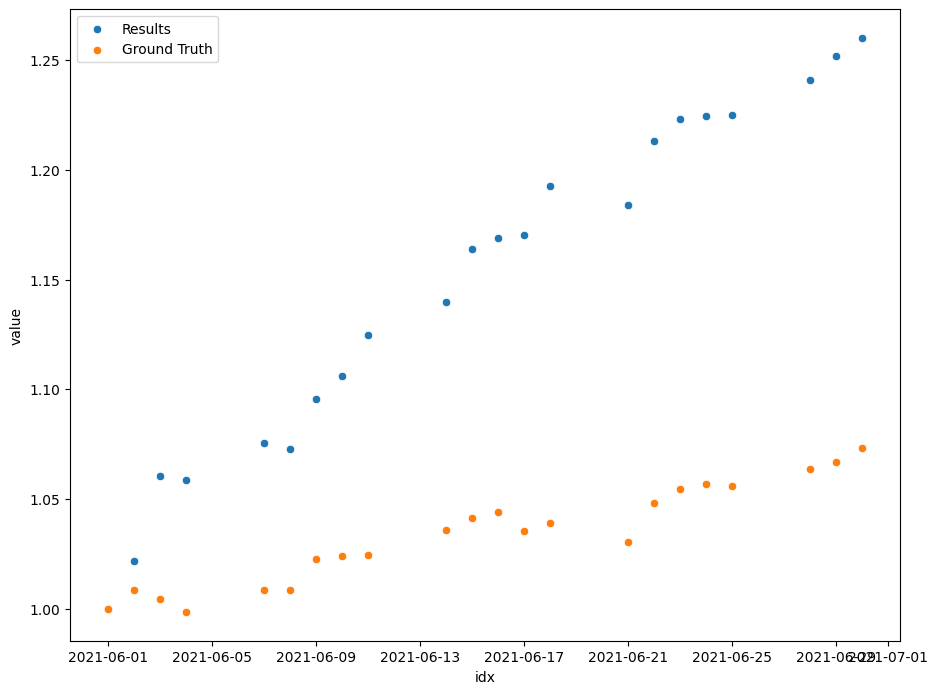

In [19]:
#fig, ax = plt.subplot(1)
fig = plt.figure(figsize=(10.708,8.2))
sns.scatterplot(x=df_results_norm.idx, y=df_results_norm.value, label='Results')
sns.scatterplot(x='ds', y=0, data=df_base, label='Ground Truth')
plt.show()

In [20]:
# self.output.to_pickle(self.save_path+'output.pkl')
# self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
# self.baseline.to_pickle(self.save_path+'baseline.pkl')